# Differentiating Human and AI Generated Text
The goal of this project is to develope a model that can accurately classify whether a section of text was written by a human or an AI (LLM). To effectively and accurately accomplish this, additional features will be extracted from the text using pre-trained models. These features along with a TF-IDF vectorization of the text itself will be used to train the model.

In order to better utilize limited computing resources and avoid re-computing sections of code, objects that are computationally intensive to create are stored using python pickle and are loaded when needed.
## Baseline

To start this project we first need to establish a baseline model for comparison later. Based on this paper *insert paper* a random forest model should perform well and can be utilized as our baseline. Since the data for this model is text, the data first has to be converted into a numerical form that the model can use. To do this the dataset will first be cleaned to remove capitalization and punctuation, after this the model will be trained using an sklearn pipeline which will perform TF-IDF vectorization on the text which is then fed to the model. 

In [1]:
#FOR TESTING ONLY
#since the code that will be presented in here takes forever to run I have been using this for testing
import string
import pandas as pd
import numpy as np
import pickle
from sklearn import feature_extraction, pipeline, metrics
from sklearn.ensemble import RandomForestClassifier

with open('PandasDF_train_clean.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('PandasDF_test_clean.pkl', 'rb') as f:
    df_test = pickle.load(f)

training_sizes = [86, 476, 866, 1732, 3464, 5196, 6062, 7794, 8659, 17317, 25976, 34635, 43294, 51952, 60611, 69270, 77928, 86587]

In [ ]:
import string
import pandas as pd
import numpy as np
from sklearn import feature_extraction, pipeline, metrics
from sklearn.ensemble import RandomForestClassifier
import pickle

df_train = pd.read_csv('final_train.csv')
df_test = pd.read_csv('final_test.csv')

def clean_data(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize each word
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
    return text

df_train['text'] = df_train['text'].apply(clean_data)
df_test['text'] = df_test['text'].apply(clean_data)

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
RF = pipeline.Pipeline([('vec',vec),('clf',RandomForestClassifier())])

# Since the dataset can take a while to clean it is pickled and saved as a .pkl file which can be loaded much faster for later use
with open('PandasDF_train_clean.pkl', 'wb') as save_train:
    pickle.dump(df_train, save_train)

with open('PandasDF_test_clean.pkl', 'wb') as save_test:
    pickle.dump(df_test, save_test)

With the data cleaned and a pipeline for the model established, we can begin to train the baseline model. However, it was at this point that an issue arose, the dataset is so large that it would take days to train the model on the full test dataset. So, a learning curve will be constucted to analyse the model's efficacy and to determine whether or not training on all 390,000 training samples is neccessary.

In [1]:
training_sizes = [86, 476, 866, 1732, 3464, 5196, 6062, 7794, 8659, 17317, 25976, 34635, 43294, 51952, 60611, 69270, 77928, 86587]

for size in training_sizes:
    X_train = df_test.iloc[:size,0]
    y_train = df_test.iloc[:size,1]
    RF.fit(X_train, y_train)
    RF_filename = "RF_" + str(size) + ".pkl"
    with open(RF_filename, 'wb') as save_rf:
        pickle.dump(RF, save_rf)

NameError: name 'df_test' is not defined

In [8]:
learning_curve = []
#this is just a stand in test range for now and can be finalized later
X_test = df_train.iloc[:1000,0]
y_test = df_train.iloc[:1000,1]

for size in training_sizes:
    RF_filename = "RF_" + str(size) + ".pkl"
    with open(RF_filename, 'rb') as load_rf:
        RF = pickle.load(load_rf)
    y_pred = RF.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    learning_curve.append([size, accuracy])

with open('learning_curve.pkl', 'wb') as save_curve:
    pickle.dump(learning_curve, save_curve)
    

Text(0, 0.5, 'Accuracy')

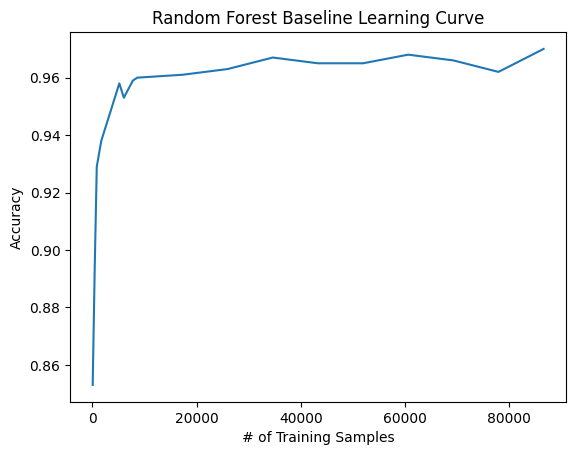

In [18]:
from matplotlib import pyplot as plt

with open('learning_curve.pkl', 'rb') as load_curve:
    curve = np.array(pickle.load(load_curve))

plt.plot(curve[:,0], curve[:,1])
plt.title('Random Forest Baseline Learning Curve')
plt.xlabel('# of Training Samples')
plt.ylabel('Accuracy')

Since this level of accuracy from the baseline model is very unexpected, a 10-fold cross validation will be performed to ensure that this level of accuracy is not a result of the train and test data selected. 

In [3]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
RF = pipeline.Pipeline([('vec',vec),('clf',RandomForestClassifier())])

cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
accuracy = cross_val_score(RF, df_test.iloc[:,0], df_test.iloc[:,1], cv=cv, scoring='accuracy')
mean_acc = np.mean(accuracy)

with open('cross_validation_score.pkl','wb') as save:
    pickle.dump(mean_acc, save)

with open('kfold_acc.pkl','wb') as save2:
    pickle.dump(accuracy, save2)

In [4]:
with open('cross_validation_score.pkl','rb') as save:
    mean_acc = pickle.load(save)

with open('kfold_acc.pkl','rb') as save:
    accuracy = pickle.load(save)

print("Accuracy for each fold:", accuracy)
print("Mean Accuracy:", mean_acc)

0.9993417053643407
[0.99907611 0.99942257 0.99919159 0.99884513 0.99965354 0.99953805
 0.99942257 0.999307   0.999538   0.9994225 ]


Since the accuracy is consistent accross the folds the high accuracy is not a result of the data chosen and is from the model learning the data.

# Feature Extraction
Put any of the code for feature extraction below or just give an overview of it.

## Confidence Extraction
Confidence.py uses the NLTK library to analyze text and calculate the percentage of sentences that do not contain any specified "insecure words," indicating a higher level of assertiveness or confidence in the text.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

class Confidence:
    def __init__(self):
        self.name = "Confidence"
         
        self.insecure_words = [
            "maybe", "possibly", "could", "might", "perhaps",
            "probably", "may", "suppose", "assume", "presume", "can", "believe", "think", "ought"
  
        ]

    def get(self, text):
        sentences = sent_tokenize(text)
        total_sentences = len(sentences)
        confident_sentences = 0

        for sentence in sentences:
             
            words = word_tokenize(sentence.lower())
             
            if not any(word in self.insecure_words for word in words):
                confident_sentences += 1

         
        confident_percentage = confident_sentences / total_sentences if total_sentences > 0 else 0

        return confident_percentage


## Correctness: 
 Correctness.py uses the language_tool_python library to assess the grammatical correctness of a given text. It initializes a grammar checking tool, identifies grammatical errors in the text, and calculates a "correctness" score based on the proportion of errors to the total number of words, ensuring the score is clamped between 0.0 and 1.0.

In [ ]:
import language_tool_python
import os
os.environ['JAVA_TOOL_OPTIONS'] = '-Xmx1024m -Xms512m'
class Correctness:
    def __init__(self, name="TextCorrectness"):
        self.name = name

    def get(self, text):
        tool = language_tool_python.LanguageTool('en-US')
        matches = tool.check(text)
        tool.close()
        errors = len(matches)
        words = text.split()
        total_words = len(words)

        if total_words == 0:
            return 1.0

        correctness = 1 - errors / total_words
        correctness = max(0.0, min(correctness, 1.0))
        return correctness

## PassiveVoice:
PassiveVoice.py uses the NLTK library to analyze sentences in a given text for passive voice construction. It checks if sentences contain a combination of 'to be' verbs followed by a past participle, which is indicative of passive voice. 

In [ ]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize

class Passivevoice:
    def __init__(self, name="Passivevoice"):
        self.name = name

    def _is_passive(self, sentence):
        tagged = pos_tag(word_tokenize(sentence))
        to_be_verbs = ['is', 'was', 'were', 'are', 'been']
        passive_pattern = [(('VBD', 'VBN'), 'NNP'), (('VBD', 'VBN'), 'NN'), (('VBZ', 'VBN'), 'NNP'), (('VBZ', 'VBN'), 'NN')]

        for i in range(len(tagged) - 1):
            if tagged[i][0].lower() in to_be_verbs and tagged[i+1][1] == 'VBN':
                return True
        return False

    def get(self, text):
        sentences = sent_tokenize(text)
        if not sentences:
            return 0.0
        
        passive_sentences = sum(1 for sentence in sentences if self._is_passive(sentence))
        return passive_sentences / len(sentences)


## Polarity:
Polarity.py uses the TextBlob library to calculate the sentiment polarity of a given text. The polarity score ranges from -1 to 1, where -1 indicates a highly negative sentiment, 1 indicates a highly positive sentiment, and 0 suggests a neutral sentiment.

In [ ]:
from textblob import TextBlob


class Polarity:
    def __init__(self):
        self.name = "Polarity"
         
    def get(self, text):
        testimonial = TextBlob(text)
        return testimonial.polarity


## Quotations:
Quotations analyzes a given text to determine the proportion of characters enclosed within quotation marks, indicating quoted speech or text. 

In [ ]:
class Quotations:
    def __init__(self):
        self.name = "Quotations"
    
    def get(self, text):
         

         
        in_quotes_count = 0
         
        in_single_quotes = False
        in_double_quotes = False

        for char in text:
             
            if char == "\"" and not in_double_quotes:   
                in_single_quotes = not in_single_quotes
            elif char == '\"' and not in_single_quotes:   
                in_double_quotes = not in_double_quotes
            
             
            if in_single_quotes or in_double_quotes:
                in_quotes_count += 1

        total_chars = len(text)

         
        if total_chars > 0:
            percentage_in_quotes = in_quotes_count / total_chars
        else:
            percentage_in_quotes = 0   

        return percentage_in_quotes


## Subjectivity
 "Subjectivity.py" uses the TextBlob library to assess the subjectivity of a given text. Subjectivity quantifies the extent to which text expresses personal opinions rather than factual information. The class calculates this by creating a TextBlob object from the text and extracting the subjectivity score, which ranges from 0 (completely objective) to 1 (highly subjective). 

In [ ]:
 from textblob import TextBlob


class Subjectivity:
    def __init__(self):
        self.name = "Subjectivity"
         
    
    def get(self, text):
        testimonial = TextBlob(text)
        return testimonial.subjectivity
